In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
%matplotlib inline

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [33]:
data = np.load("data.npy")
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

data += signal.square(2 * np.pi * 0.1 * t)  # add a square wave to the data

#### Create Transform Object and Analysis Filters

In [84]:
"Pad Length"
fb = DyadicFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=4*5000, real=True, s_max = 10, dj = 1/18, compensation=False)

transform = Transform(
    data=data,
    fs = sample_rate,
    filterbank=fb,
)

print(fb.compensation)

False


Text(0.5, 0, 'Frequency Channel')

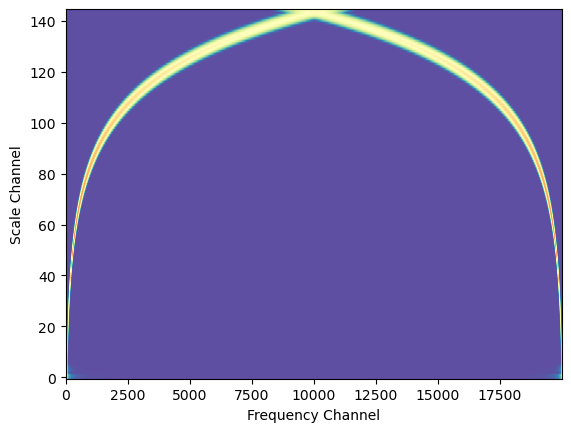

In [85]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

#### Transform and Inverse the Data

RMSE:  7.695306331126205e-12


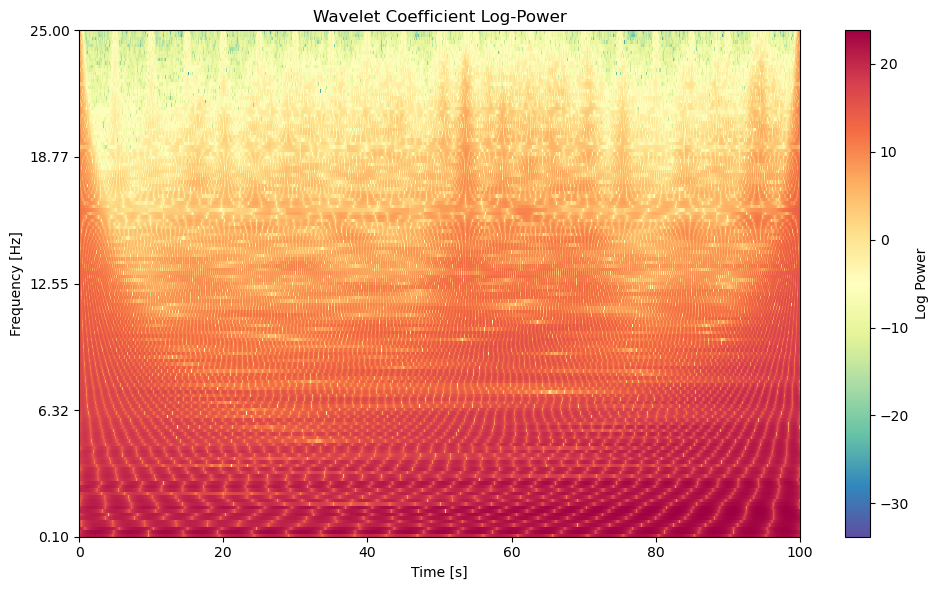

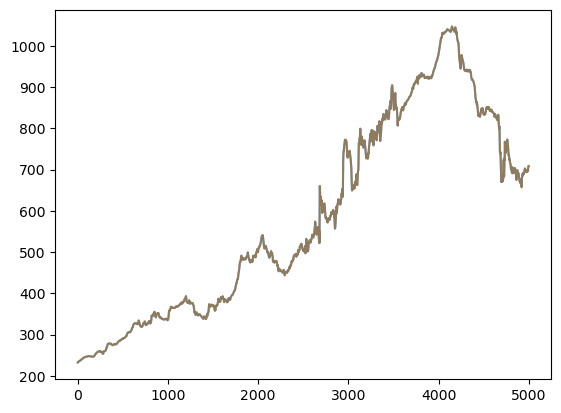

In [86]:
# Perform forward wavelet transform
coefficients = transform.forward(data, mode='same')
transform.scalogram(coefficients, cmap =  'Spectral_r')

# Perform inverse wavelet transform (reconstruction)
reconstructed = transform.inverse(coefficients)
fig, ax = plt.subplots(1,1)
plt.plot(reconstructed)
plt.plot(data, alpha=0.5)
print("RMSE: ", np.sqrt(np.mean((reconstructed - data)**2)))

Reconstruction error: 7.695306331126205e-12


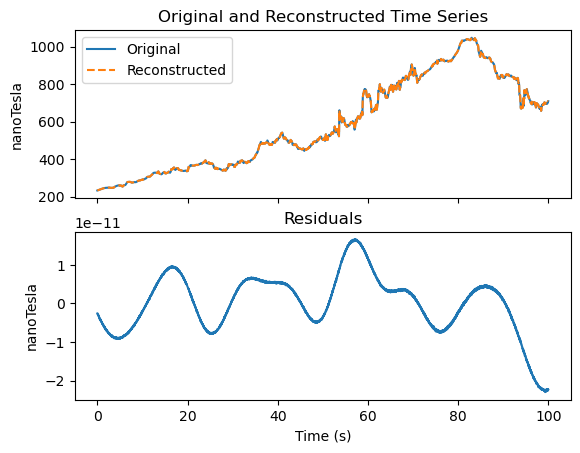

In [87]:
# Perform forward wavelet transform
coefficients = transform.forward(data, mode='full')

# Perform inverse wavelet transform (reconstruction)
reconstructed = transform.inverse(coefficients)

# Calculate and print reconstruction error
reconstruction_error = np.sqrt(np.mean((reconstructed - data)**2))
print(f"Reconstruction error: {reconstruction_error}")

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, data, label='Original')
ax[0].plot(t, reconstructed, label='Reconstructed', linestyle='--')    
ax[0].set_ylabel('nanoTesla')
ax[0].legend()
ax[0].set_title('Original and Reconstructed Time Series')
ax[1].plot(t, data - reconstructed)
ax[1].set_title('Residuals')
ax[1].set_ylabel('nanoTesla')
ax[1].set_xlabel('Time (s)')
plt.show()

c:\Users\Alex\Documents\GitHub\InvertibleWavelets\invertiblewavelets\transform.py:281: RuntimeWarning: divide by zero encountered in log
  np.log(power),


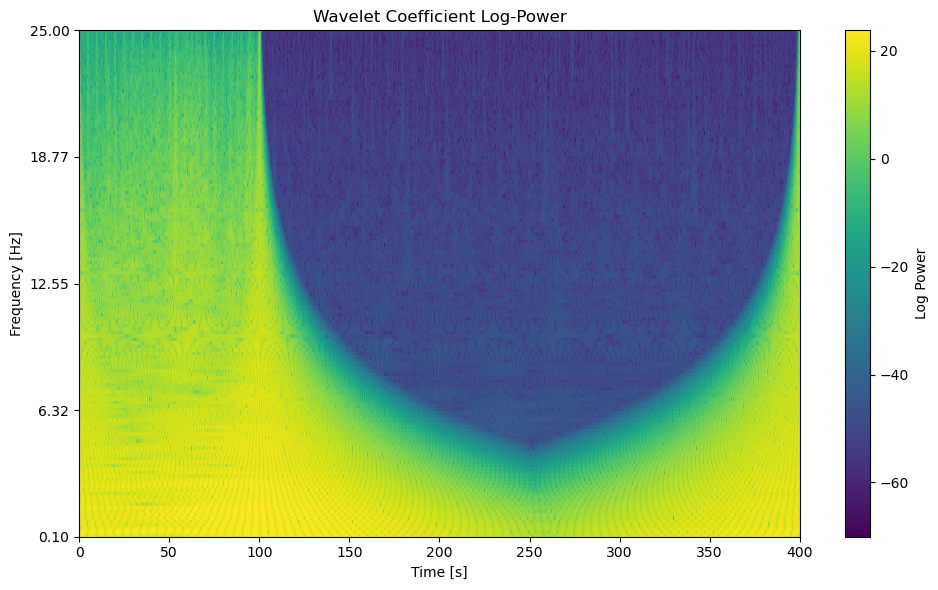

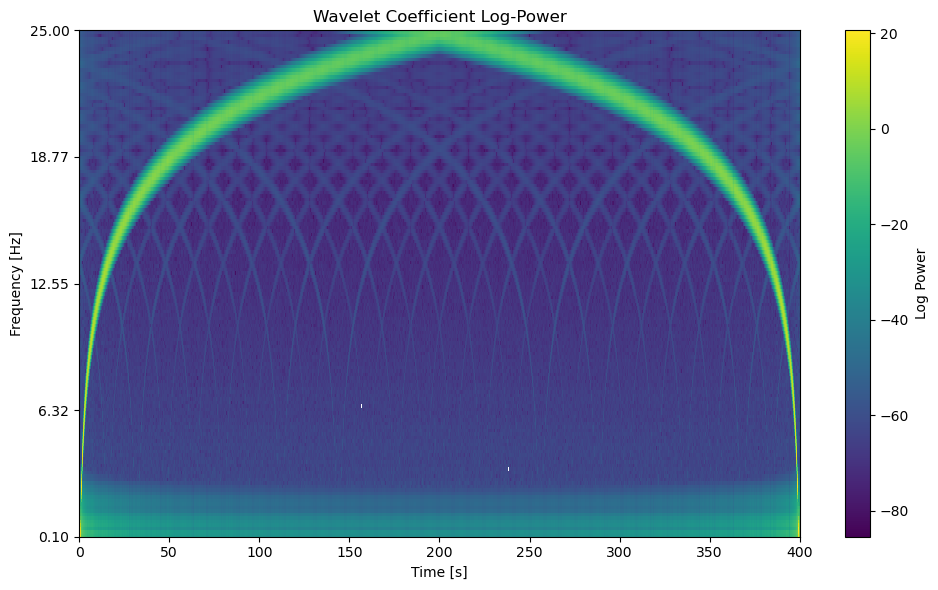

In [88]:
transform.scalogram(coefficients)
transform.scalogram(np.fft.ifft(coefficients, axis=1))

#### Check the wavelet spectral coverage

#### Check Wavelet Orthgonality

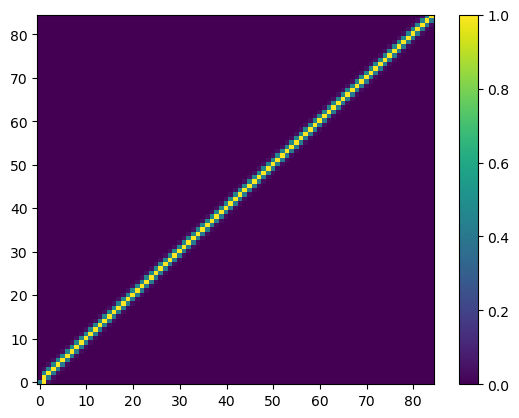

In [10]:
w_time = np.fft.ifft(transform.Wfreq, axis=-1)
delta_kl = w_time.conj() @ w_time.T
delta_kl = delta_kl / np.max(delta_kl, axis=1)[:, np.newaxis]
plt.imshow(np.abs(delta_kl), aspect='auto', origin='lower')
cbar = plt.colorbar()

#### Check Spectral Leakage

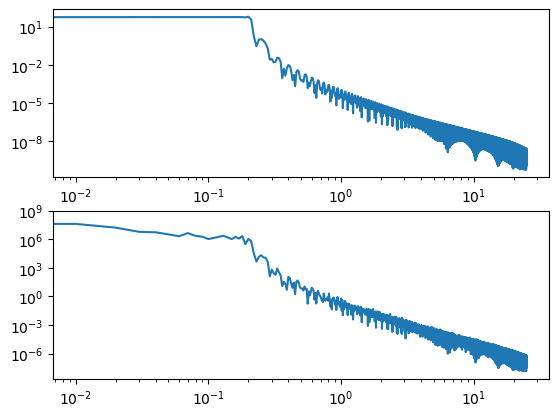

In [9]:
fig, ax = plt.subplots(2,1)
i = 0
N = coefficients.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(coefficients, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')